# Multilayer Perceptron from scratch

Referensi dari video bu Afia

In [ ]:
from random import random
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
def sigmoid(x):
  return 1.0 / (1.0 + math.exp(-x))

In [ ]:
def mse(output, target):
  err = 0
  for outp, targ in zip(output, target):
    err += 1/2 * (outp - targ)**2
  return err

##class Network 
Berisi 3 layer: input, hidden dan output. Tiap layer berisi neuron yang berisi:
- `weights`: array np berisi weight tiap neuron dari layer sebelumnya ke dirinya
- `bias`  : nilai bias untuk neuron ini, dipakai untuk menghitung nilai aktivasi
- `output`: nilai output untuk neuron ini, yaitu nilai aktivasinya

In [ ]:
class Network:
  def __init__(self, inp_n = 0, hid_n = 0, out_n = 0):
    self.shape = {'input': inp_n, 'hidden': hid_n, 'output': out_n}
    self.layers = [
                  # hidden layer
                  [{
                      'weights' : np.array([random() for i in range(inp_n)]),
                      'bias'    : random(),
                      'output'  : 0
                  } for j in range(hid_n)],
                   
                  # output layer
                  [{
                      'weights' : np.array([random() for i in range(hid_n)]),
                      'bias'    : random(),
                      'output'  : 0
                  } for j in range(out_n)]
    ]
  
 
  # Forward propagate
  # Tiap neuron di hidden dihitung aktivasinya, kemudian dibawa ke output layer
  # Return sebuah array berisi aktivasi dari tiap neuron output layer
  def forward(self, data):
    # Input ke hidden
    for neuron in self.layers[0]:
      neuron['output'] = sigmoid(np.dot(data, neuron['weights']) + neuron['bias'])
 
    hid_array = [neuron['output'] for neuron in self.layers[0]]
    
    # Hidden ke output
    for neuron in self.layers[1]:
      neuron['output'] = sigmoid(np.dot(hid_array, neuron['weights']) + neuron['bias'])
    
    out_array = [neuron['output'] for neuron in self.layers[1]]
 
    return out_array
 
  # Backward propagate
  # Pertama delta tiap output neuron dicari dengan rumus
  # delta = (aktivasi - prediksi) * aktivasi * (1 - aktivasi)
  # kemudian bobot hidden -> output diupdate pake rumus
  # nwe_weight = old_weight - learn_rate*delta*
  def backward(self, data, output, target, learn_rate):
      delta_array_out = []
      # output ke hidden
      ## cari delta tiap output neuron
      for index, neuron in enumerate(self.layers[1]):
        delta = (neuron['output'] - target[index]) * neuron['output'] * (1 - neuron['output'])
        delta_array_out.append(delta)
      
      ## update bobot axon dari hidden ke output
      for index, neuron in enumerate(self.layers[1]):
        new_weights = [neuron['weights'][i] - (learn_rate * delta_array_out[index] * self.layers[0][i]['output']) for i in range(len(neuron['weights']))]
        neuron['weights'] = new_weights
        neuron['bias'] = neuron['bias'] - learn_rate * delta_array_out[index]
      
      
      delta_array_hid = []
      # hidden ke input
      ## cari delta tiap hidden neuron
      for index, neuron in enumerate(self.layers[0]):
        inweight = [neur['weights'][index] for neur in self.layers[1]]
        potential = np.dot(inweight, delta_array_out)
        delta = potential * neuron['output'] * (1 - neuron['output'])
        delta_array_hid.append(delta)
      
      ## update bobot axon dari input ke hidden
      for index, neuron in enumerate(self.layers[0]):
        new_weights = [neuron['weights'][i] - (learn_rate * delta_array_hid[index] * data[i]) for i in range(len(neuron['weights']))]
        neuron['weights'] = new_weights
        neuron['bias'] = neuron['bias'] - learn_rate * delta_array_hid[index]
   
 
  def train(self, dataset, labels, epochs = 1, learn_rate = 0.5):
    errors = []
    accuracies = []
    for i in range(epochs):
      error = 0
      correct = 0
      print('Training epoch', i + 1, '...')
      for data, label in zip(dataset, labels):
        #print('data:', *data)
        out_array = self.forward(data)
        if(out_array.index(max(out_array)) == label):
          correct += 1
        label_array = [1 if i == label else 0 for i in range(len(self.layers[1]))]
        error += mse(out_array, label_array)
        self.backward(data, out_array, label_array, learn_rate)
      print('Error:', error, '\n')
      errors.append(error)
      accuracies.append(correct / len(dataset))
    
    print('Training done')
 
    return errors, accuracies
  
  def test(self, dataset, labels):
    print('Testing start...\n')
    correct = 0
    for data, label in zip(dataset, labels):
      output = self.forward(data)
      prediction = output.index(max(output))
      print('predicted', prediction, 'should be', label, end = '')
      if(prediction == label):
        print('....ok')
        correct += 1
      else:
        print('....miss')
    
    return correct / len(dataset)
  
  def predict(self, dataset):
    predictions = []
    for data in dataset:
      output = self.forward(data)
      prediction = output.index(max(output))
      predictions.append(prediction)
    
    return prediction

In [ ]:
def main():
  iris = load_iris()
  zip_iris = zip(iris['data'], iris['target'])
  dataset = [[[], []], [[], []], [[], []]]
 
  for data in zip_iris:
    dataset[data[1]][0].append(data[0])
    dataset[data[1]][1].append(data[1])
 
  # train test split
  X_train, y_train, X_test, y_test = [], [], [], []
 
  for flower in dataset:
    X = flower[0] # data feature
    y = flower[1] # label
    
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size = 0.2)
 
    X_train.extend(Xtr)
    y_train.extend(ytr)
    X_test.extend(Xte)
    y_test.extend(yte)
 
  X_train, y_train = shuffle(X_train, y_train)
 
  # Init network
  network = Network(4, 10, 3)
 
  # TRAIN
  errors, accuracy = network.train(X_train, y_train, epochs = 50, learn_rate = 0.1)
 
  print('Input -> Hidden weights')
  for i in range(network.shape['hidden']):
    print(network.layers[0][i]['weights'])
 
  print('\nHidden -> Output weights')
  for i in range(network.shape['output']):
    print(network.layers[1][i]['weights'])
 
  # plot errors and accuracy
  plt.plot(errors, color = 'r')
  plt.title('Error per Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.show()
 
  plt.plot(accuracy, color = 'g')
  plt.title('Accuracy per Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.show()
 
  # TEST
  accuracy = network.test(X_test, y_test)
  print('Test Accuracy:', accuracy)

Training epoch 1 ...
Error: 118.5418615034275 

Training epoch 2 ...
Error: 109.08589387482245 

Training epoch 3 ...
Error: 92.08924951007083 

Training epoch 4 ...
Error: 75.31981027600398 

Training epoch 5 ...
Error: 66.0613812383095 

Training epoch 6 ...
Error: 46.88382699221985 

Training epoch 7 ...
Error: 40.85957375524844 

Training epoch 8 ...
Error: 38.41624319848427 

Training epoch 9 ...
Error: 34.316532331689906 

Training epoch 10 ...
Error: 30.876742815715374 

Training epoch 11 ...
Error: 28.188186196787573 

Training epoch 12 ...
Error: 26.32006858793714 

Training epoch 13 ...
Error: 25.059176821430388 

Training epoch 14 ...
Error: 24.191479752472965 

Training epoch 15 ...
Error: 23.57257051697371 

Training epoch 16 ...
Error: 23.1135638466731 

Training epoch 17 ...
Error: 22.75984974252339 

Training epoch 18 ...
Error: 22.47673743713913 

Training epoch 19 ...
Error: 22.240818737060145 

Training epoch 20 ...
Error: 22.034372117072056 

Training epoch 21 ...
E

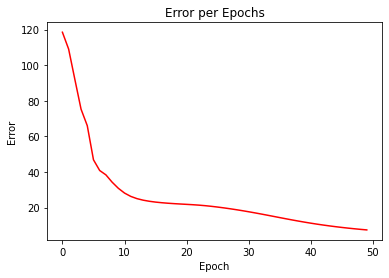

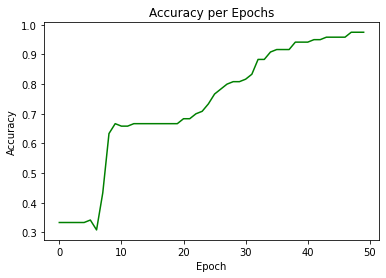

Testing start...

predicted 0 should be 0....ok
predicted 0 should be 0....ok
predicted 0 should be 0....ok
predicted 0 should be 0....ok
predicted 0 should be 0....ok
predicted 0 should be 0....ok
predicted 0 should be 0....ok
predicted 0 should be 0....ok
predicted 0 should be 0....ok
predicted 0 should be 0....ok
predicted 1 should be 1....ok
predicted 1 should be 1....ok
predicted 2 should be 1....miss
predicted 1 should be 1....ok
predicted 1 should be 1....ok
predicted 1 should be 1....ok
predicted 1 should be 1....ok
predicted 1 should be 1....ok
predicted 1 should be 1....ok
predicted 2 should be 1....miss
predicted 2 should be 2....ok
predicted 2 should be 2....ok
predicted 2 should be 2....ok
predicted 2 should be 2....ok
predicted 2 should be 2....ok
predicted 2 should be 2....ok
predicted 2 should be 2....ok
predicted 2 should be 2....ok
predicted 2 should be 2....ok
predicted 2 should be 2....ok
Test Accuracy: 0.9333333333333333


In [ ]:
# Run main
main()
